<div align="center">
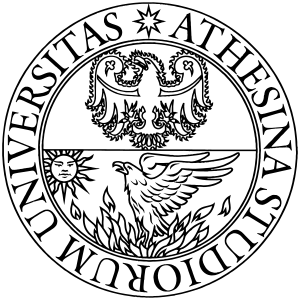
</div>

<center><h1> AI for Finance 2023 - MATTEO MINARDI [MAT. 238789]

<hr>

# About the project

The project consists on trying to predict the price of a future's contract based on multiple approaches. <br> It's common knowledge that prices of items in the market are almost impossible to predict, since the market isn't based on predefined statistical patterns, but this project shows how someone could try to solve this task with different input ingredients and draw different conclusions. 

More precisely, the objective will be to predict the price of one of Apple's future's contracts. <br> 
The data is taken from the Eikon database, so it is really high quality and needs little-to-no cleaning.<br>
Before going deeper into the solutions, this notebook also provides a general, yet still unrealistic, intuition into the problem. 

Multiple regressions have been tried, with ***different approaches***:

- Based on old stock <u>prices</u>
- Based on old percetage <u>returns</u> 
- Incorporating <u>the market and Sentiment Analysis of the news system</u>

For each method, an OLS has been computed to check the R squared values and the significance of the parameters. <br>

With each approach, two methods have been performed: one not-so-fair, trying to predict the future values relying on future data that wouldn't be available in a real life scenario, just to show and ideal case, and a second one done in the correct way but obviously on a shorter forecast window.

Each approach will be discussed in a more exhaustive way in its dedicated section.

<hr>

# Boilerplate code
## Importing libraries and setting up the Eikon API

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import eikon as ek
import pandas as pd
import numpy as np
import cufflinks as cf
import nltk, bs4
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import configparser as cp
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from datetime import datetime

This small section allows to connect to the Eikon database in order to retrieve the necessary data. <br> For this initial part, the only two necessary series are the prices of both the specific future's contract and the price of the Apple stock.

In [3]:
cfg = cp.ConfigParser()
cfg.read('eikon.cfg')

['eikon.cfg']

In [4]:
ek.set_app_key(cfg['eikon']['app_id'])

Downloading the timeseries about Apple stock prices and the future's contract prices, and in addition computing the SPREAD

In [5]:
start_date = '2021-01-01'
end_date = '2023-05-30'

Printing the table of data

In [6]:
data = pd.DataFrame()
data['AAPL.O'] = ek.get_timeseries('AAPL.O', fields = 'CLOSE', start_date = start_date, end_date = end_date, interval = 'daily')['CLOSE']
data['AAPF3N3'] = ek.get_timeseries('AAPF3N3', fields = 'CLOSE', start_date = start_date, end_date = end_date, interval = 'daily')['CLOSE']
data['SPREAD'] = data['AAPL.O'] - data['AAPF3N3']
data.dropna(inplace = True)
data

,AAPL.O,AAPF3N3,SPREAD
Date,,,
2022-06-21,135.87,140.653,-4.783
2022-06-22,135.35,140.2974,-4.9474
2022-06-23,138.27,141.1666,-2.8966
2022-06-24,141.66,143.9489,-2.2889
2022-06-27,141.66,146.8889,-5.2289
...,...,...,...
2023-05-23,171.56,174.3047,-2.7447
2023-05-24,171.84,172.3466,-0.5066
2023-05-25,172.99,173.3871,-0.3971


<hr>

## General intuition: ideal (unrealistic) case

Visualizing **ideal** results, assuming to split a hypothetical dataset right where the dotted line is placed, trying to predict the evolution of the price of the contract, training it on the price of the main stock, and seeing how they might behave in the future. 

In [7]:
def compute_days_between_dates(date1, date2):
    date_format = "%Y-%m-%d"
    datetime1 = datetime.strptime(date1, date_format)
    datetime2 = datetime.strptime(date2, date_format)

    delta = datetime2 - datetime1
    num_days = delta.days

    return num_days

days_between = compute_days_between_dates(str(data.index[0].date()), str(data.index[-1].date()))
split_date = datetime.strptime(str(data.index[0].date()), "%Y-%m-%d")
split_date = split_date + pd.DateOffset(days = days_between * 2 // 3)

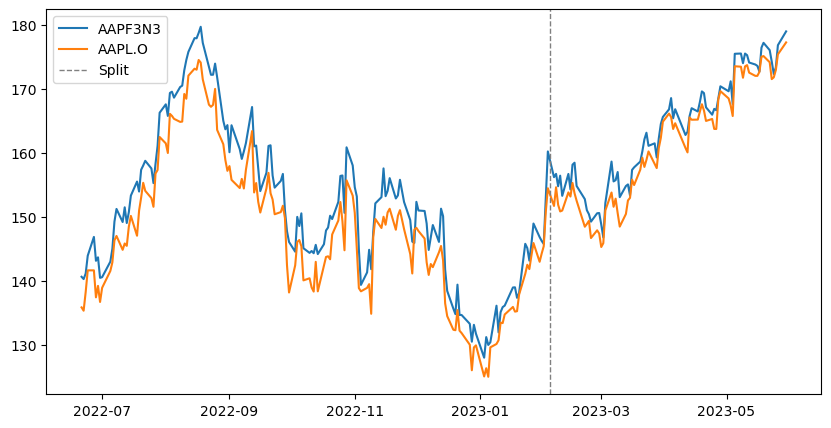

In [8]:
plt.figure(figsize=(10, 5))

plt.plot(data['AAPF3N3'], label = 'AAPF3N3')
plt.plot(data['AAPL.O'], label = 'AAPL.O')

plt.axvline(x = split_date, color = 'gray', linestyle = '--', linewidth = 1, label = 'Split')

plt.legend()
plt.show()

Visualizing correlation between series, it's even more clear to see how much the price of a future's contract depends on the price of the main stock, with the absolute SPEAD resulting less important than expected. <br> <br> This is surely because the $R^2$ is already explanatory enough and the absolute difference in price is not that important, since we just care if the prices themselves are just going to increase or decrease. 

<AxesSubplot:>

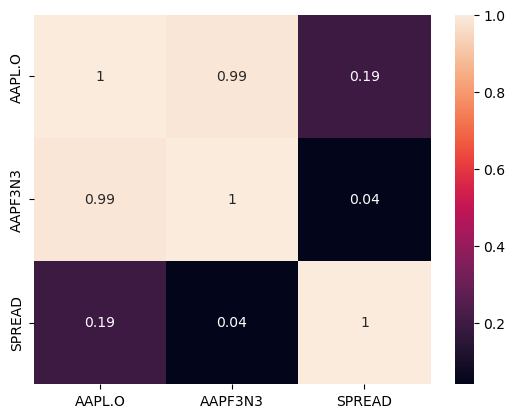

In [9]:
vif = pd.DataFrame(data,columns=data.columns)

sns.heatmap(vif.corr().abs(),annot=True)

<hr>

# Regression using old prices

Actual regression trying to predict the proce of a future's contract given the price of the main stock, using a Random Forest estimator. <br><br>
This estimator is great because it's able to generalize in a very simple way to almost any kind of data, and since this regression isn't particularly difficult it will work perfectly fine.

The analysis has been done both in a not-so-correct way, which means trynig to predict the future's contract prices assuming to know the prices of the Apple stock in the future, and another, with a window of just one prediction, where it is correctly assumed to not know anything about the future, as it is in reality. 

Defining what we will use for the prediction, and subdiving the dataset into a train set and a test set, that will be used to test the accuracy obtained.

In [10]:
X = data.loc[:, data.columns != 'AAPF3N3']
y = data['AAPF3N3']
split = len(X) * 2 // 3

X_train, y_train, X_test, y_test = X[:split], y[:split], X[split:], y[split:]

<h3>OLS model for econometric statistics

Given the fact that the price of the Apple stock and the contract have almost a correlation of 1, it was expected that also the R-squared was going to be 1, since obviously the Apple price is extremely significant for the estimate. 

In [11]:
X_sm = sm.add_constant(np.array(X.reset_index()[['AAPL.O', 'SPREAD']], dtype=float))
model = sm.OLS(np.array(y.reset_index()['AAPF3N3'], dtype=float), X_sm)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.875e+30
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        09:54:10   Log-Likelihood:                 6763.7
No. Observations:                 235   AIC:                        -1.352e+04
Df Residuals:                     232   BIC:                        -1.351e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.279e-13   6.62e-14     -1.933      0.054   -2.58e-13    2.47e-15
x1             1.0000   4.17e-16    2.4e+15      0.000       1.000       1.000
x2            -1.0000   2.73e-15  -3.66e+14      0.000      -1.000      -1.000
==============================================================================
Omnibus:                        5.135   Durbin-Watson:                   0.244
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                3.497
Skew:                          -0.138   Prob(JB):                        0.174
Kurtosis:                       2.469   Cond. No.                     2.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h4> 1. Not-so-fair prediction 

First, the not-so-fair prediciton: it's clear to see that if we could know the prices that the Apple's stock would assume in the future, it would be pretty easy to compute the related future's contract prices since they are extremely correlated. Unfortunately this is not how it works in real life.

Accuracy score: 0.9411076156426474
Pearson correlation: 0.9919436924369929


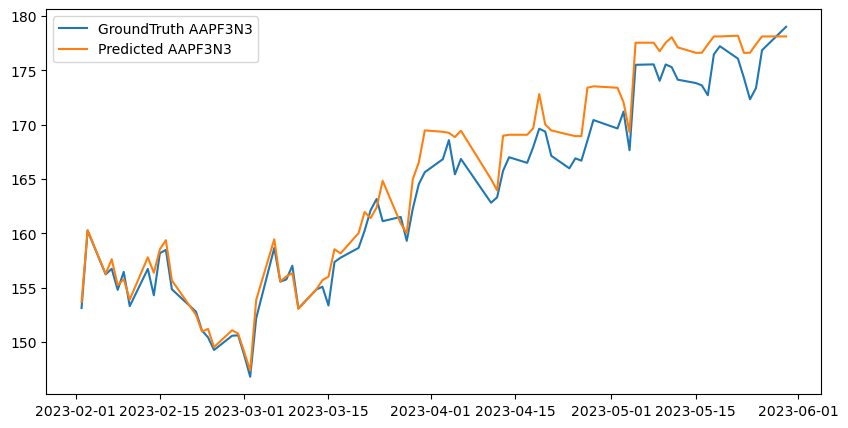

In [12]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)
model.fit(X_train, y_train)

print('Accuracy score:', model.score(X_test, y_test))

predicted_vals = model.predict(X_test)

print('Pearson correlation:', pearsonr(y_test, predicted_vals)[0])

plt.figure(figsize=(10, 5))
plt.plot(X_test.index, y_test, label = 'GroundTruth AAPF3N3')
plt.plot(X_test.index, predicted_vals, label = 'Predicted AAPF3N3')
plt.legend()

Now also showing ad unfair training using a LSTM, that will soon later be used in a fair way, just for a quick comparison. <br>
The model is trained to predict a single output value given the series of the 10 previous input values, so its output will tend to have a move average-like evolution compared to the actual observed value. 

In [13]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

Epoch 1/20
6/6 [==============================] - 4s 148ms/step - loss: 0.2955 - val_loss: 0.0269
Epoch 2/20
6/6 [==============================] - 0s 30ms/step - loss: 0.0919 - val_loss: 0.0123
Epoch 3/20
6/6 [==============================] - 0s 28ms/step - loss: 0.0235 - val_loss: 0.0440
Epoch 4/20
6/6 [==============================] - 0s 28ms/step - loss: 0.0315 - val_loss: 0.0288
Epoch 5/20
6/6 [==============================] - 0s 28ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 6/20
6/6 [==============================] - 0s 29ms/step - loss: 0.0163 - val_loss: 0.0135
Epoch 7/20
6/6 [==============================] - 0s 30ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch 8/20
6/6 [==============================] - 0s 29ms/step - loss: 0.0135 - val_loss: 0.0214
Epoch 9/20
6/6 [==============================] - 0s 27ms/step - loss: 0.0136 - val_loss: 0.0220
Epoch 10/20
6/6 [==============================] - 0s 32ms/step - loss: 0.0131 - val_loss: 0.0195
Epoch 11/20
6/6 [===========

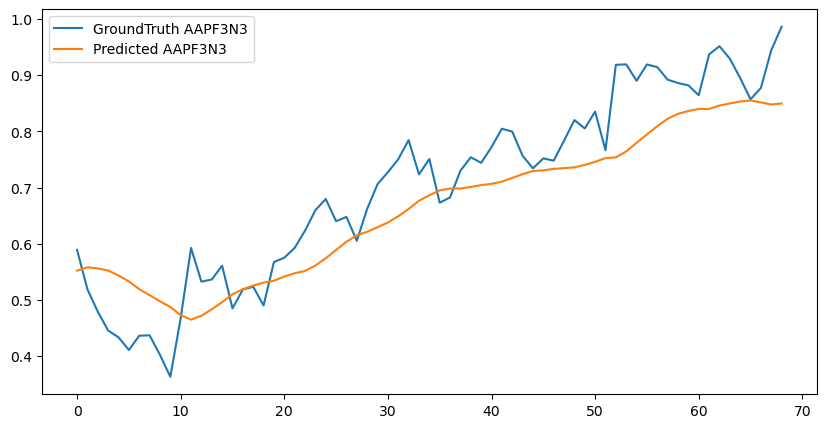

In [15]:
y = data['AAPF3N3']

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_y = scaler.fit_transform(y.values.reshape(-1, 1))

window_size = 10
test_split = len(normalized_y) * 2 // 3
val_split = split * 2 // 3

train_data = normalized_y[:val_split]
val_data   = normalized_y[val_split:test_split]
test_data  = normalized_y[test_split:]

normalized_y_X_train, normalized_y_y_train = create_sequences(train_data, window_size)
normalized_y_X_val,   normalized_y_y_val   = create_sequences(val_data, window_size)
normalized_y_X_test,  normalized_y_y_test  = create_sequences(test_data, window_size)

model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(normalized_y_X_train, normalized_y_y_train, epochs=20, batch_size=16, validation_data=(normalized_y_X_val, normalized_y_y_val))

predicted_prices = model.predict(normalized_y_X_test)
predicted_vals = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(normalized_y_y_test.flatten(), label = 'GroundTruth AAPF3N3')
plt.plot(predicted_vals.flatten(), label = 'Predicted AAPF3N3')
plt.legend()

<h4> 2. Fair prediction

Now, for a real life case approach, the price of the future's contract will be estimated using only truly available data. <br>
This means that the future prices will be predicted only using prices available until "today", hence why only one future timestep can be predicted. 

In order to be able to achieve this, a lag to the output series is necessary, so that the model can learn to predict the future. <br>
Only a single lag will be applied since it will only output a single value, that we can compare with the last ground truth of the downloaded series.   

In [16]:
X = data.loc[:, data.columns != 'AAPF3N3'][:-1]
y = data['AAPF3N3'].shift(-1).dropna()
split = len(X) - 1

X_train, y_train, X_test, y_test = X[:split], y[:split], X[split:], y[split:]

And now it's possible to run a simple regression, like the preceding case.

In [17]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)
model.fit(X_train, y_train)

predicted_val = model.predict(X_test)

print('Accuracy score:', 1 - (predicted_val[0] - y_test[0])**2)
print('Predicted value:', predicted_val[0])
print('GroundTruth value:', y_test[0])

Accuracy score: 0.9968941058794363
Predicted value: 0.9303200797880049
GroundTruth value: 0.9860506290456943


One could also decide to try to predict even further in the future, using previous predicitons to influece later ones. This approach can sometimes be meaningful, but generally it's not recommended since everytime we make a prediction we are introducing some error, and using those values to predict other ones might generate even more errors along the way.  
<br>
Now trying to predict future prices only given the prices of the single contract, thus trying to make that single time series predict itself. <br><br>
To make this happen, window sequences are generated, so that it's possible to slide that window across the data and try to predict each following value given the 10 values before, and using predicted values as input to even further ones.

As expected, the results are not perfect but still pretty ok.

Epoch 1/20
10/10 [==============================] - 3s 26ms/step - loss: 0.1382
Epoch 2/20
10/10 [==============================] - 0s 18ms/step - loss: 0.0186
Epoch 3/20
10/10 [==============================] - 0s 18ms/step - loss: 0.0154
Epoch 4/20
10/10 [==============================] - 0s 19ms/step - loss: 0.0148
Epoch 5/20
10/10 [==============================] - 0s 18ms/step - loss: 0.0129
Epoch 6/20
10/10 [==============================] - 0s 17ms/step - loss: 0.0123
Epoch 7/20
10/10 [==============================] - 0s 18ms/step - loss: 0.0129
Epoch 8/20
10/10 [==============================] - 0s 18ms/step - loss: 0.0124
Epoch 9/20
10/10 [==============================] - 0s 17ms/step - loss: 0.0123
Epoch 10/20
10/10 [==============================] - 0s 17ms/step - loss: 0.0118
Epoch 11/20
10/10 [==============================] - 0s 18ms/step - loss: 0.0121
Epoch 12/20
10/10 [==============================] - 0s 17ms/step - loss: 0.0110
Epoch 13/20
10/10 [==================

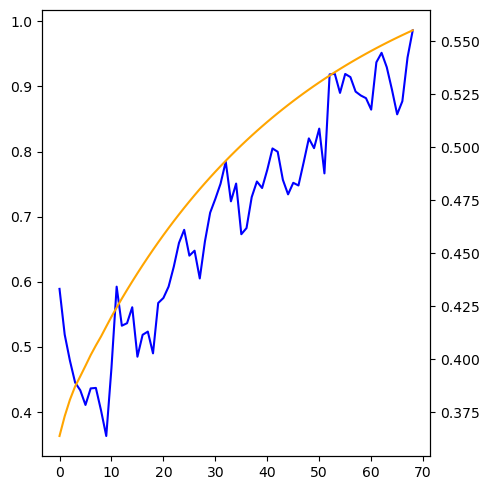

In [18]:
y = data['AAPF3N3']

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_y = scaler.fit_transform(y.values.reshape(-1, 1))

window_size = 10
test_split = len(normalized_y) * 2 // 3
val_split = split * 2 // 3

train_data = normalized_y[:val_split]
val_data = normalized_y[val_split:test_split]
test_data = normalized_y[test_split:]

X_train, y_train = create_sequences(train_data, window_size)
X_val, y_val = create_sequences(val_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))

last_sequence = train_data[-window_size:]
predicted_prices = []
for _ in range(len(y_test)):
    predicted_price = model.predict(last_sequence.reshape(1, window_size, 1))
    predicted_prices.append(predicted_price[0, 0])
    last_sequence = np.append(last_sequence[1:], predicted_price[0, 0])
# predicted_prices = model.predict(X_test)
predicted_vals = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.plot(y_test.flatten(), label = 'GroundTruth AAPF3N3', color = 'blue')
ax2 = axes.twinx()
ax2.plot(predicted_vals.flatten(), label = 'Predicted AAPF3N3', color = 'orange')
plt.tight_layout()

plt.show()

<hr>

# Regression using old returns 

Returns are a way to analyze the performances of a stock, without the need to look at the absolute values of the prices. <br><br>
This approach is definitely more general than the previous one because it allows to compare two different stocks that might be behaving in the same way, but it's not easy to notice since their absolute values might be on completely different scales, probably because the sizes of the related companies are too different. So percentage values sometimes are extremely helpful.

In this case it has been noticed to ***not*** be as effective as anticipated.

Returns are computed taking the differece between a price at timestep $t$ and at timestep $t-1$, and dividing it by the value at timestep $t-1$, so each value represents how much a price increased or decreased, compared to the previous timestep. <br>
In short: $$r_{t} = \frac{p_t - p_{t-1}}{p_{t-1}}$$

In [19]:
aapl_returns, aapf3n3_returns = [], []

for i in range(1, len(data)):
    aapl_returns.append(round((data['AAPL.O'][i] - data['AAPL.O'][i - 1]) / data['AAPL.O'][i - 1], 3))
    aapf3n3_returns.append(round((data['AAPF3N3'][i] - data['AAPF3N3'][i - 1]) / data['AAPF3N3'][i - 1], 3))

aapl_returns.insert(0, aapl_returns[0])
aapf3n3_returns.insert(0, aapf3n3_returns[0])

data['AAPL.O Returns'] = aapl_returns 
data['AAPF3N3 Returns'] = aapf3n3_returns 

Since this operation may introduce hard-to-work-with values, the means of both the Apple returns and the SPREAD are being computed so that they can be used instead, without causing significant damage to the series.

In [20]:
X = data[['AAPL.O Returns', 'SPREAD']]
y = data['AAPF3N3 Returns']
split = len(X) * 2 // 3

X_train, y_train, X_test, y_test = X[:split], y[:split], X[split:], y[split:]

returns_mean_value = X_train['AAPL.O Returns'].mean()  
spread_mean_value = X_train['SPREAD'].mean()

X_train['AAPL.O Returns'] = X_train['AAPL.O Returns'].fillna(returns_mean_value)  
X_train['SPREAD'] = X_train['SPREAD'].fillna(spread_mean_value)

X_train['AAPL.O Returns'] = X_train['AAPL.O Returns'].replace([np.inf, -np.inf], returns_mean_value)
X_train['SPREAD'] = X_train['SPREAD'].replace([np.inf, -np.inf], spread_mean_value)

In [21]:
def find_nonfinite_index_replace(arr):
    arr = np.array(arr)  
    mask = np.logical_not(np.isfinite(arr)) 
    if np.all(mask):
        return -1, arr  
    else:
        mean = np.mean(arr[np.isfinite(arr)]) 
        arr[mask] = mean  
        return np.argmax(mask), arr   

In [22]:
index, X_train = find_nonfinite_index_replace(np.array(X_train.reset_index()[['AAPL.O Returns', 'SPREAD']], dtype=float))
index, y_train = find_nonfinite_index_replace(y_train)
np.all(np.isfinite(X_train)), np.all(np.isfinite(y_train))

(True, True)

<h3>OLS model for econometric statistics

Now that the highest correlated parameter (Apple stock price) is not present, we can see that the R squared decreased a lot since the returns are a lot less explanatory.

In [23]:
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     36.92
Date:                Fri, 23 Jun 2023   Prob (F-statistic):           8.27e-14
Time:                        09:55:51   Log-Likelihood:                 1.7985
No. Observations:                 156   AIC:                             2.403
Df Residuals:                     153   BIC:                             11.55
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2432      0.057     -4.298      0.000      -0.355      -0.131
x1             9.1995      1.072      8.586      0.000       7.083      11.316
x2            -0.0633      0.013     -4.945      0.000      -0.089      -0.038
==============================================================================
Omnibus:                      212.538   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14294.630
Skew:                           5.406   Prob(JB):                         0.00
Kurtosis:                      48.632   Cond. No.                         255.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h4> 1. Not-so-fair prediction

Comparing the results to the previous case, we can see that the accuracy score has decreased a lot, but this is just derivated by the fact that we are now working with percentages. <br><br>
In fact, looking at the correlation between the predicted values and the ground truth ones, it's clear to see that the results are actually pretty good, since in reality we care only to know if the prices are either going up or down.

Accuracy score: -1.2899827408175244
Pearson correlation: 0.6975355377738479


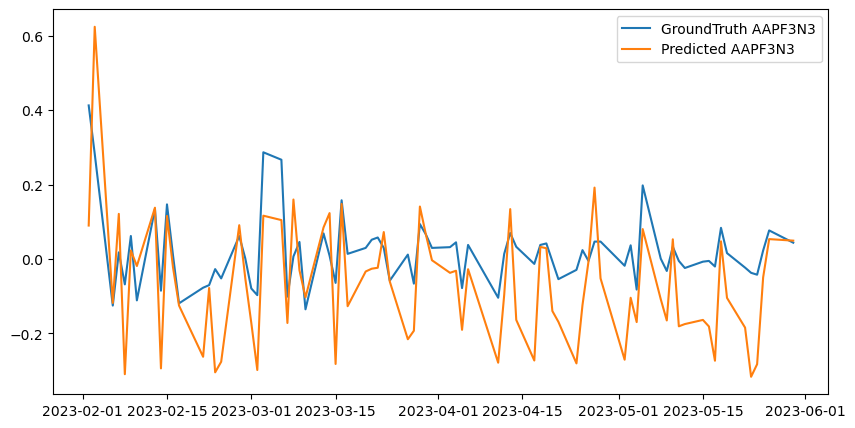

In [24]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)
model.fit(X_train, y_train)

print('Accuracy score:', model.score(X_test, y_test))

predicted_vals = model.predict(X_test)

print('Pearson correlation:', pearsonr(y_test, predicted_vals)[0])

plt.figure(figsize=(10, 5))
plt.plot(X_test.index, y_test, label = 'GroundTruth AAPF3N3')
plt.plot(X_test.index, predicted_vals, label = 'Predicted AAPF3N3')
plt.legend()

Again showing the behaviour of an unfairly trained LSTM model with this kind of data. <br>
As mentioned before, since in these situations LSTM models tend to assume an average-like behaviour, it's returning values very close to zero, being able to follow some increasing or decreasing patterns but not following them to their extremes.

Epoch 1/30
6/6 [==============================] - 4s 148ms/step - loss: 0.0548 - val_loss: 0.0432
Epoch 2/30
6/6 [==============================] - 0s 32ms/step - loss: 0.0074 - val_loss: 0.0256
Epoch 3/30
6/6 [==============================] - 0s 30ms/step - loss: 0.0064 - val_loss: 0.0292
Epoch 4/30
6/6 [==============================] - 0s 30ms/step - loss: 0.0037 - val_loss: 0.0246
Epoch 5/30
6/6 [==============================] - 0s 30ms/step - loss: 0.0020 - val_loss: 0.0261
Epoch 6/30
6/6 [==============================] - 0s 30ms/step - loss: 0.0028 - val_loss: 0.0255
Epoch 7/30
6/6 [==============================] - 0s 30ms/step - loss: 0.0019 - val_loss: 0.0245
Epoch 8/30
6/6 [==============================] - 0s 27ms/step - loss: 0.0017 - val_loss: 0.0247
Epoch 9/30
6/6 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0246
Epoch 10/30
6/6 [==============================] - 0s 30ms/step - loss: 0.0016 - val_loss: 0.0246
Epoch 11/30
6/6 [===========

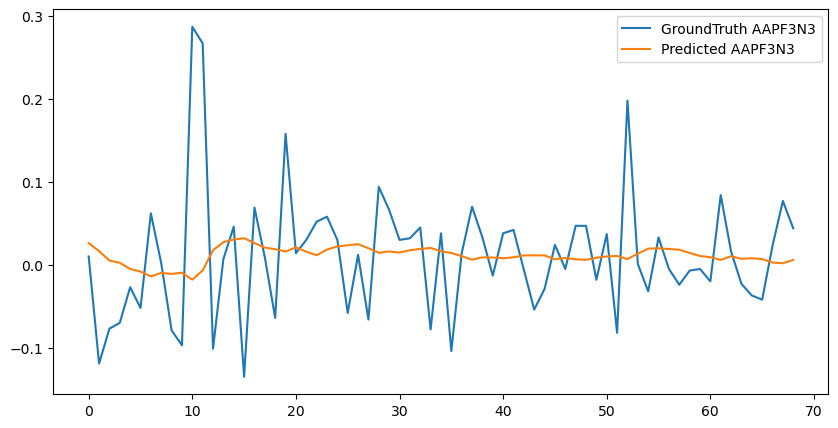

In [25]:
y = data['AAPF3N3 Returns'] 

index, y = find_nonfinite_index_replace(y)

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_y = scaler.fit_transform(y.reshape(-1, 1))

window_size = 10
test_split = len(normalized_y) * 2 // 3
val_split = split * 2 // 3

train_data = normalized_y[:val_split]
val_data = normalized_y[val_split:test_split]
test_data = normalized_y[test_split:]

X_train, y_train = create_sequences(train_data, window_size)
X_val, y_val = create_sequences(val_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))

predicted_prices = model.predict(X_test)

predicted_vals = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))
y_test = scaler.inverse_transform(y_test)

print('Pearson correlation:', pearsonr(y_test.flatten(), predicted_vals.flatten())[0])

plt.figure(figsize=(10, 5))
plt.plot(y_test.flatten(), label = 'GroundTruth AAPF3N3')
plt.plot(predicted_vals.flatten(), label = 'Predicted AAPF3N3')
plt.legend()

<h4> 2. Fair prediction

As in the previous approach, it's more fair to try to predict only a single future value, taking in input only available data, like in an applicable scenario. <br> Again, it's needed to apply a single lag to the input values for the same reason explained before. 

In [26]:
X = data[['AAPL.O Returns', 'SPREAD']][:-1]
y = data['AAPF3N3 Returns'].shift(-1).dropna()
split = len(X) - 1

X_train, y_train, X_test, y_test = X[:split], y[:split], X[split:], y[split:]

returns_mean_value = X_train['AAPL.O Returns'].mean()  
spread_mean_value = X_train['SPREAD'].mean()
y_mean_value = y_train.mean()

X_train['AAPL.O Returns'] = X_train['AAPL.O Returns'].fillna(returns_mean_value)  
X_train['SPREAD'] = X_train['SPREAD'].fillna(spread_mean_value)
y_train = y_train.fillna(y_mean_value)

X_train['AAPL.O Returns'] = X_train['AAPL.O Returns'].replace([np.inf, -np.inf], returns_mean_value)
X_train['SPREAD'] = X_train['SPREAD'].replace([np.inf, -np.inf], spread_mean_value)
y_train = y_train.replace([np.inf, -np.inf], y_mean_value)

And now it's possible to run a simple regression, like the preceding case.

In [27]:
index, y_train = find_nonfinite_index_replace(y_train)
np.all(np.isfinite(y_train))

True

In [28]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)
model.fit(X_train, y_train)


predicted_val = model.predict(X_test)

print('Accuracy score:', 1 - (predicted_val[0] - y_test[0])**2)
print('Predicted value:', predicted_val[0])
print('GroundTruth value:', y_test[0])

Accuracy score: 0.9999361599
Predicted value: 0.05198999999999999
GroundTruth value: 0.044


To replicate the previous reasoning, it has been tried again the sliding window regression approach. <br><br>
In this case, results aren't as satisfiying, but this is usually what happens in real cases. The model is able to estimate the correct behaviour at the start, but right after it doesn't know what to do so it flattens.

Epoch 1/30
10/10 [==============================] - 3s 25ms/step - loss: 0.0648
Epoch 2/30
10/10 [==============================] - 0s 19ms/step - loss: 0.0117
Epoch 3/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0093
Epoch 4/30
10/10 [==============================] - 0s 19ms/step - loss: 0.0094
Epoch 5/30
10/10 [==============================] - 0s 19ms/step - loss: 0.0089
Epoch 6/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0082
Epoch 7/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0087
Epoch 8/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0087
Epoch 9/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0082
Epoch 10/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0081
Epoch 11/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0082
Epoch 12/30
10/10 [==============================] - 0s 18ms/step - loss: 0.0083
Epoch 13/30
10/10 [==================

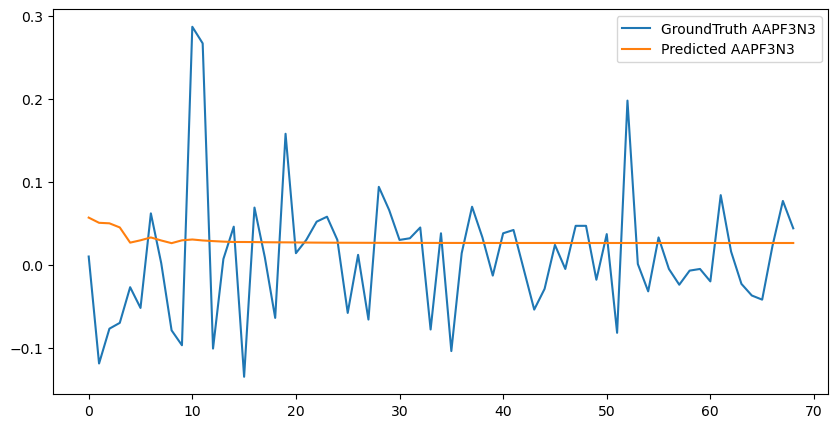

In [29]:
y = data['AAPF3N3 Returns'] 

index, y = find_nonfinite_index_replace(y)

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_y = scaler.fit_transform(y.reshape(-1, 1))

window_size = 10
test_split = len(normalized_y) * 2 // 3
val_split = split * 2 // 3

train_data = normalized_y[:val_split]
val_data = normalized_y[val_split:test_split]
test_data = normalized_y[test_split:]

X_train, y_train = create_sequences(train_data, window_size)
X_val, y_val = create_sequences(val_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))

last_sequence = train_data[-window_size:]
predicted_prices = []
for _ in range(len(y_test)):
    predicted_price = model.predict(last_sequence.reshape(1, window_size, 1))
    predicted_prices.append(predicted_price[0, 0])
    last_sequence = np.append(last_sequence[1:], predicted_price[0, 0])

predicted_vals = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))
y_test = scaler.inverse_transform(y_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test.flatten(), label = 'GroundTruth AAPF3N3')
plt.plot(predicted_vals.flatten(), label = 'Predicted AAPF3N3')
plt.legend()

<hr>

# Incorporating Sentiment Analysis and SP500

A more advanced approach would be to consider more information. <br><br>
Sentiment Analysis is the process of ‘computationally’ determining whether a piece of writing is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speaker.
<br><br> Since it's known that the market is heavily influed by people's feeling and fears, it would be appropriate to start considering a sentiment analysis over the news of the specific stock and use it as additional information for the final prediction, since, for example, bad news are probably very correlated with losses in the market.
<br><br>
In order to try to increase the performance even more, it has been decided to also consider the market performance, using the SP500 index. This could be useful to have a sort of baseline for performance comparison. 

To make everything less computationally expensive, only news headlines will be analized and the sentiment analysis will be done searching for specific word tokens that might refer to either positive or negative news. <br> As expected and as shown later, most news are actually neutral.  

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. <br> PUNKT is a tokenizer.

In [30]:
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\matte\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matte\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Downloading news form January,1 2021 to June,1 2023 about both the Apple stock and the SP500, in order to have a meaningful amout of data to work with.

In [31]:
sp500_news_list = []
apple_news_list = []
start_date = '2021-01-01'
end_date = '2023-06-01'

tmp_date_from = start_date
step = int(tmp_date_from[-5:-3]) + 1
tmp_year = tmp_date_from[:4]
tmp_date_to = tmp_year + '-' + str(step).zfill(2) + tmp_date_from[-3:]

while pd.to_datetime(tmp_date_from) != pd.to_datetime(end_date):
    print(tmp_date_from, tmp_date_to)
    try:
        sp500_news_list.append(ek.get_news_headlines('0#.SPX', date_from = tmp_date_from, date_to = tmp_date_to, count = 100))
        apple_news_list.append(ek.get_news_headlines('AAPL.O', date_from = tmp_date_from, date_to = tmp_date_to, count = 100))
    except:
        pass
    
    step = int(tmp_date_to[-5:-3]) + 1
    tmp_date_from = tmp_date_to    

    if step > 12:
        step = 1
        tmp_year = str(int(tmp_year) + 1)        
        
    tmp_date_to = tmp_year + '-' + str(step).zfill(2) + tmp_date_from[-3:]

2021-01-01 2021-02-01
2021-02-01 2021-03-01
2021-03-01 2021-04-01
2021-04-01 2021-05-01
2021-05-01 2021-06-01
2021-06-01 2021-07-01
2021-07-01 2021-08-01
2021-08-01 2021-09-01
2021-09-01 2021-10-01
2021-10-01 2021-11-01
2021-11-01 2021-12-01
2021-12-01 2022-01-01
2022-01-01 2022-02-01
2022-02-01 2022-03-01
2022-03-01 2022-04-01
2022-04-01 2022-05-01
2022-05-01 2022-06-01
2022-06-01 2022-07-01
2022-07-01 2022-08-01
2022-08-01 2022-09-01
2022-09-01 2022-10-01
2022-10-01 2022-11-01
2022-11-01 2022-12-01
2022-12-01 2023-01-01
2023-01-01 2023-02-01
2023-02-01 2023-03-01
2023-03-01 2023-04-01
2023-04-01 2023-05-01
2023-05-01 2023-06-01


In [32]:
len(sp500_news_list), len(apple_news_list)

(29, 29)

This cell just shows one of Eikon's issues: it does not let users download data older than 15 months, so the biggest amount of collectable news for a given stock is 100 (for each month) times 15.
<br>
<br>
In total, we dispone of $100 * 15 = 1500$ news for both Apple and SP500, for a combined of $1500 * 2 = 3000$ articles to analyze. 

In [33]:
for i in range(len(sp500_news_list)):
    print(i, sp500_news_list[i].shape, apple_news_list[i].shape)

0 (0, 4) (0, 4)
1 (0, 4) (0, 4)
2 (0, 4) (0, 4)
3 (0, 4) (0, 4)
4 (0, 4) (0, 4)
5 (0, 4) (0, 4)
6 (0, 4) (0, 4)
7 (0, 4) (0, 4)
8 (0, 4) (0, 4)
9 (0, 4) (0, 4)
10 (0, 4) (0, 4)
11 (0, 4) (0, 4)
12 (0, 4) (0, 4)
13 (0, 4) (0, 4)
14 (100, 4) (100, 4)
15 (100, 4) (100, 4)
16 (100, 4) (100, 4)
17 (100, 4) (100, 4)
18 (100, 4) (100, 4)
19 (100, 4) (100, 4)
20 (100, 4) (100, 4)
21 (100, 4) (100, 4)
22 (100, 4) (100, 4)
23 (100, 4) (100, 4)
24 (100, 4) (100, 4)
25 (100, 4) (100, 4)
26 (100, 4) (100, 4)
27 (100, 4) (100, 4)
28 (100, 4) (100, 4)


In [34]:
sp500_news_list = sp500_news_list[-15:]
apple_news_list = apple_news_list[-15:]
for i in range(len(sp500_news_list)):
    print(i, sp500_news_list[i].shape, apple_news_list[i].shape)

0 (100, 4) (100, 4)
1 (100, 4) (100, 4)
2 (100, 4) (100, 4)
3 (100, 4) (100, 4)
4 (100, 4) (100, 4)
5 (100, 4) (100, 4)
6 (100, 4) (100, 4)
7 (100, 4) (100, 4)
8 (100, 4) (100, 4)
9 (100, 4) (100, 4)
10 (100, 4) (100, 4)
11 (100, 4) (100, 4)
12 (100, 4) (100, 4)
13 (100, 4) (100, 4)
14 (100, 4) (100, 4)


<h3> Computing polarity scores </h3>

Each headline will be assigned to a value between $-1$ and $1$. <br> 
For instance, a positive value refers to a positive sentiment detected. A value close to zero implies a neutral case.

In [35]:
sid = SentimentIntensityAnalyzer()

In [36]:
sp500_sentiment = pd.DataFrame()
for sp500_news in sp500_news_list:
    for title in sp500_news['text']:
        row = sp500_news[sp500_news['text'] == title]
        scores = sid.polarity_scores(row['text'][0])
        sp500_sentiment = pd.concat(objs = [sp500_sentiment, pd.DataFrame(scores, index = [row['versionCreated'][0]])])

sp500_sentiment.index = pd.DatetimeIndex(sp500_sentiment.index)
sp500_sentiment.sort_index(inplace = True)

In [37]:
apple_sentiment = pd.DataFrame()
for apple_news in apple_news_list:
    for title in apple_news['text']:
        row = apple_news[apple_news['text'] == title]
        scores = sid.polarity_scores(row['text'][0])
        apple_sentiment = pd.concat(objs = [apple_sentiment, pd.DataFrame(scores, index = [row['versionCreated'][0]])])

apple_sentiment.index = pd.DatetimeIndex(apple_sentiment.index)
apple_sentiment.sort_index(inplace = True)

For each news set, we get a table with the structure of the following one. <br>
It's possible to see how the vast majority of scores are neutral. <br>
The compound column basically represents an aggregation of the preceding three, being able to represent a general idea underlying a certain stock.

In [38]:
sp500_sentiment.describe()

,neg,neu,pos,compound
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.031041,0.889045,0.079919,0.080444
std,0.080063,0.138177,0.113606,0.276212
min,0.000000,0.204000,0.000000,-0.911600
25%,0.000000,0.794000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.179000,0.340000
max,0.512000,1.000000,0.796000,0.953700


In [39]:
apple_sentiment.describe()

,neg,neu,pos,compound
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.037616,0.916661,0.045722,0.019930
std,0.091362,0.133476,0.097798,0.262624
min,0.000000,0.423000,0.000000,-0.836000
25%,0.000000,0.828000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000
max,0.548000,1.000000,0.577000,0.939300


Plotting the compound distribution of both SP500 and Apple. <br>
Again, this shows how many distinct news are labelled with the same polarity, for each polarity score. <br>
<br>
As anticipated, the biggest amount of news are neutral, but not in the same way.

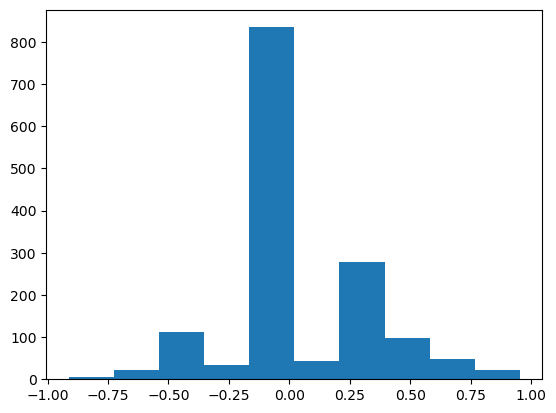

In [40]:
plt.hist(sp500_sentiment['compound'])
plt.show()

For SP500, the values are slightly distributed with a little skew towards the positive side (+1). <br> This implies that for the SP500 news are typically neutral or positive, while for Apple they are very much more evenly distributed, making it more difficult to say to which side they tend to lean on.

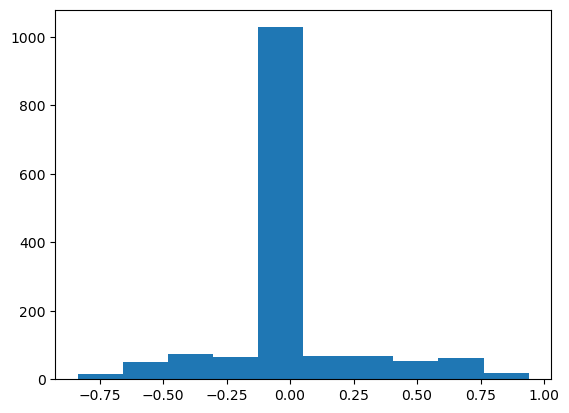

In [41]:
plt.hist(apple_sentiment['compound'])
plt.show()

<h3> Integrating cumulative sum of sentiment scores

Summing up all the sentiment scores, grouping them by their date, allows to compute a general sentiment score for each time step. <br>
This measure is used to identify particular moments in which the general public opinion changed, meaning it increased by a significant amount or decreased surprisingly.

Its functioning is almost self explanatory: if the sum of the sentiment scores for each day is greater than zero, it means that it was a positive day, while it's the opposite for the negative case, and stable at zero for the neutral one. 

This first graph shows the almost-linearly increasing cumulative sum of the sentiment scores of the SP500. <br>
From this graph we can notice two main dates in which the news generated extremely positive scores, which resulted in two jumps on the graph.
<br><br>
As expected, this graph is very stable, because it's very unlikely that something is able to shift the entire market, unless it's really groundbreaking or extremely influential in the way everyone lives.

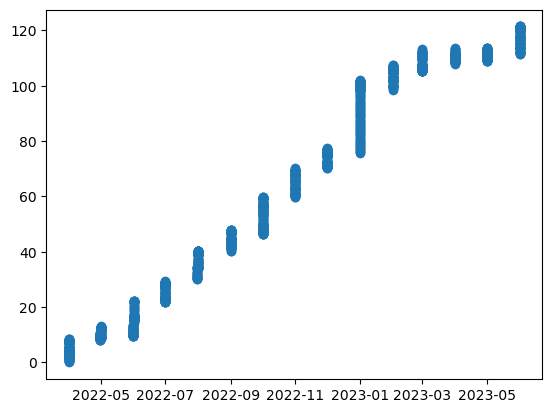

In [42]:
plt.scatter(sp500_sentiment.index, sp500_sentiment['compound'].cumsum())

On the other hand, the cumulative sum of Apple's sentiments is much more volatile. <br>
This is completely normal as a single stock will always be more volatile than the entire market, since the second one is basically the mean of all the stocks. <br><br>
In this case it's easy to spot both some positive trends and negative ones, as expected.

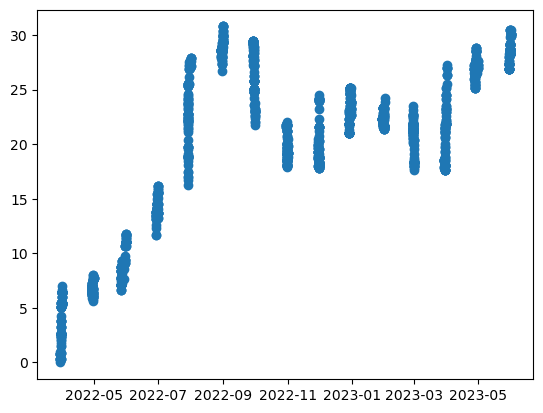

In [43]:
plt.scatter(apple_sentiment.index, apple_sentiment['compound'].cumsum())

<h3> Quantizing sentiment scores

This operation subdivides all the different values of the sentiment scores that are originally continuously distributed between $-1$ and $-1$, into $3$ bins where they assume exactly either $-1$, $0$ or $1$. So it discretizes the continuous domain in order to make it more simple.

The two following cells show how the values have been subdivided. <br>
Since we are discretizing into 3 bins of the same size, it has been decided to subdivide the domain into thirds. 

In [44]:
sp500_sentiment['transform'] = sp500_sentiment['compound'].apply(lambda x: 1 if x > 1/3 else -1 if x < -1/3 else 0)
sp500_sentiment['transform'].value_counts()

 0    981
 1    376
-1    143
Name: transform, dtype: int64

In [45]:
apple_sentiment['transform'] = apple_sentiment['compound'].apply(lambda x: 1 if x > 1/3 else -1 if x < -1/3 else 0)
apple_sentiment['transform'].value_counts()

 0    1197
 1     170
-1     133
Name: transform, dtype: int64

This is how the cumulative sum of the updated domains look like. <br>
We can see that their behaviour is not significantly different than the original one, hence we can conclude that we did not alter the information in a bad way and that most information has been preserved correctly.

***SP500***

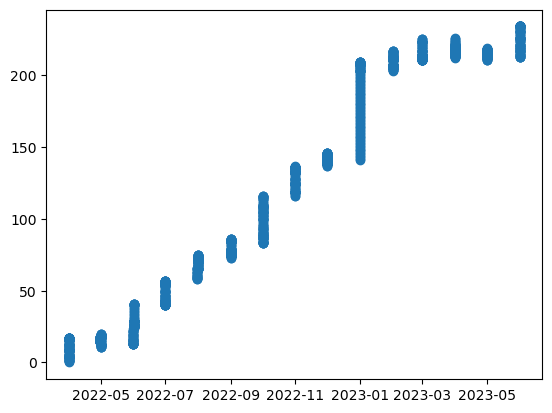

In [46]:
plt.scatter(sp500_sentiment.index, sp500_sentiment['transform'].cumsum())

***APPLE***

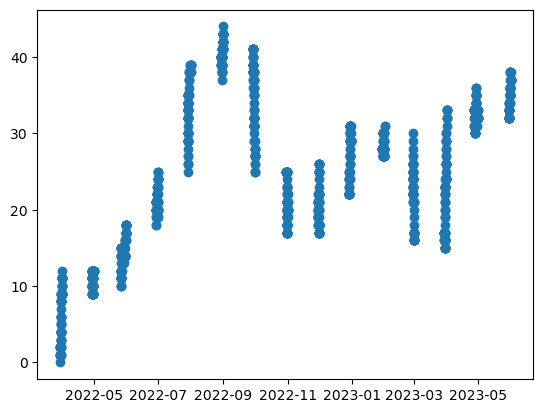

In [47]:
plt.scatter(apple_sentiment.index, apple_sentiment['transform'].cumsum())

<h3> Confronting the patterns

Now that all the useful information is available, let's plot all the series against each other to spot any useful patterns. <br>
<br>
First, we need to aggregate the values of the cumulative series just computed. In this case it has been used the mean to have a stable estimate.

In [48]:
sp500_daily = sp500_sentiment['compound'].cumsum().resample('D').last().ffill()
apple_daily = apple_sentiment['compound'].cumsum().resample('D').last().ffill()
sp500data = ek.get_timeseries('.SP500', fields = 'CLOSE', start_date = start_date, end_date = end_date, interval = 'daily')['CLOSE']

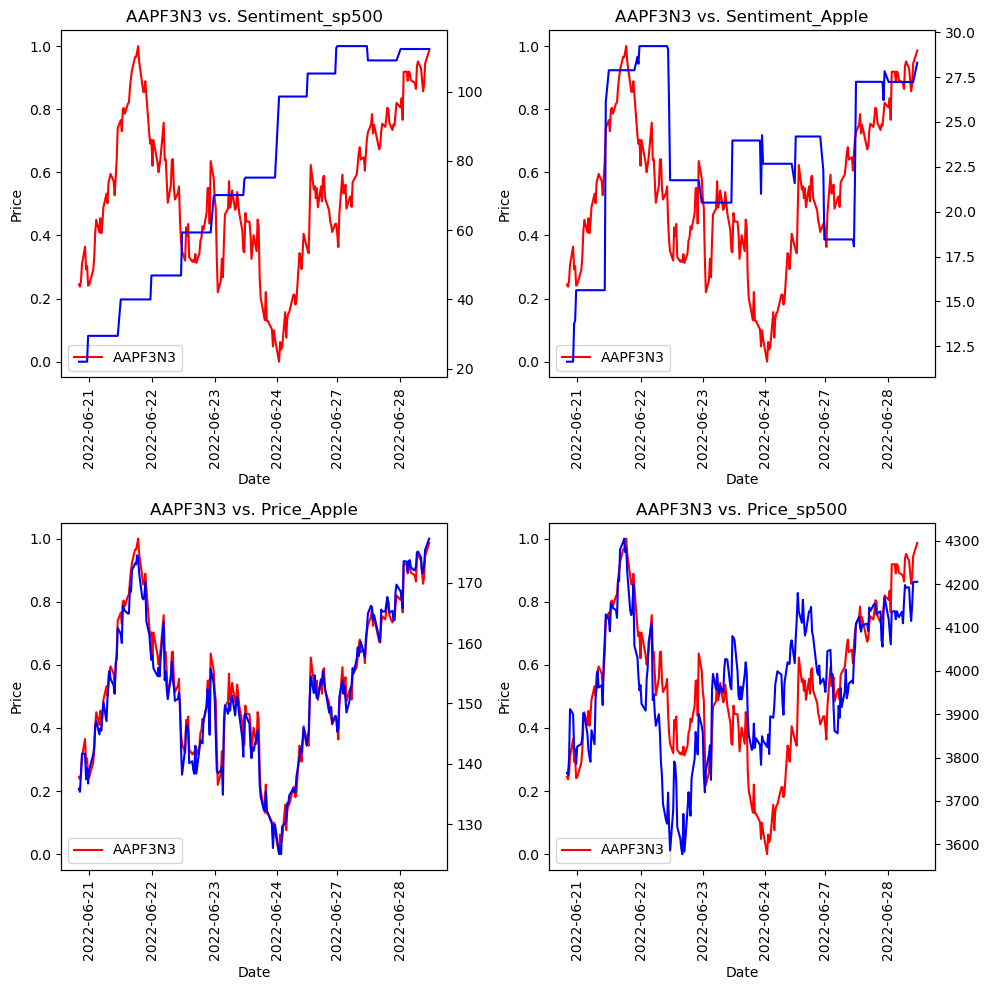

In [49]:
target = data['AAPF3N3'] 
auxiliary_data = [sp500_daily, apple_daily, data['AAPL.O'], sp500data]

for aux in auxiliary_data:
    to_drop = []
    for i in range(len(aux.index)):
        if aux.index[i] not in target.index:
            to_drop.append(aux.index[i])
    aux.drop(to_drop, inplace = True)

labels_auxiliary_data = ['Sentiment_sp500', 'Sentiment_Apple', 'Price_Apple', 'Price_sp500']
x_vals = []

for i in range(len(target)):
    x_vals.append(target.index[i].date())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i in range(2):
    for j in range(2):
        axes[i, j].plot(target, color = 'red', label = 'AAPF3N3')
        ax2 = axes[i, j].twinx()
        ax2.plot(auxiliary_data[i * 2 + j], color = 'blue', label = labels_auxiliary_data[i * 2 + j])
        axes[i, j].legend(loc = 'best')
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Price')
        axes[i, j].set_title('AAPF3N3 vs. '+ labels_auxiliary_data[i * 2 + j])
        axes[i, j].set_xticklabels(x_vals, rotation='vertical')

plt.tight_layout()

plt.show()

<h3> Organizing the data for the last predictions 

Merging them together into a single dataframe so that it's easier to compute the future predicitons.

In [50]:
df = pd.DataFrame()
df['AAPF3N3'] = target
df['Sentiment sp500'] = auxiliary_data[0].values
df['Sentiment Apple'] = auxiliary_data[1].values
df['Price Apple'] = auxiliary_data[2]
df['Price sp500'] = auxiliary_data[3]
df

,AAPF3N3,Sentiment sp500,Sentiment Apple,Price Apple,Price sp500
Date,,,,,
2022-06-21,0.244461,21.9799,11.6421,135.87,3764.788
2022-06-22,0.237588,21.9799,11.6421,135.35,3759.8931
2022-06-23,0.254388,21.9799,11.6421,138.27,3795.7274
2022-06-24,0.308166,21.9799,11.6421,141.66,3911.7439
2022-06-27,0.364991,21.9799,11.6421,141.66,3900.1141
...,...,...,...,...,...
2023-05-23,0.894897,112.3252,27.2255,171.56,4145.5752
2023-05-24,0.85705,112.3252,27.2255,171.84,4115.2386
2023-05-25,0.877162,112.3252,27.2255,172.99,4151.2799


Also plotting the pair-wise correlations of the new series. <br>
In general, the shared information between variables is definitely significant. Excluding the correlation between the future contract's price and Apple's price discussed earlier, it clear to see that also the sentiment analysis could be very useful. <br>
<br>
As expected, the sentiment analysis of the Apple side is clearly more significant than the general SP500 one. 

<AxesSubplot:>

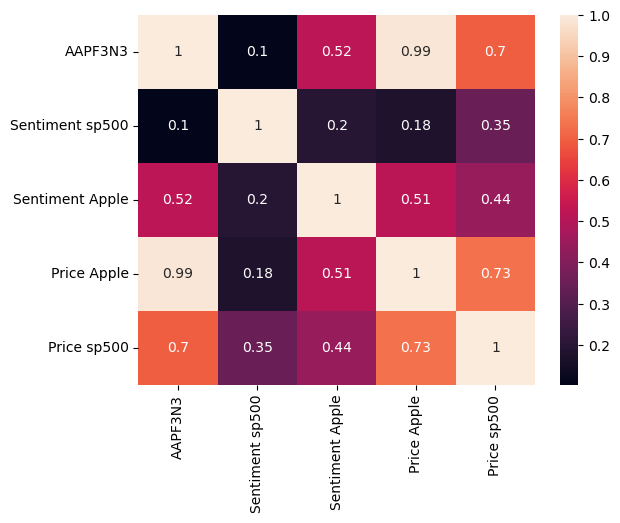

In [51]:
vif = pd.DataFrame(df,columns=df.columns)

sns.heatmap(vif.corr().abs(),annot=True)

<h3>OLS model for econometric statistics

Again, this model seems to have a very high R sqared, probably due to the fact that it contains the Apple stock price.

In [52]:
X_sm = sm.add_constant(np.array(df.reset_index()[['Sentiment sp500','Sentiment Apple','Price Apple','Price sp500']], dtype=float))
model = sm.OLS(np.array(df.reset_index()['AAPF3N3'], dtype=float), X_sm)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     3234.
Date:                Fri, 23 Jun 2023   Prob (F-statistic):          8.38e-201
Time:                        10:01:06   Log-Likelihood:                 484.47
No. Observations:                 235   AIC:                            -958.9
Df Residuals:                     230   BIC:                            -941.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2049      0.058    -38.306      0.000      -2.318      -2.091
x1            -0.0005   7.11e-05     -7.356      0.000      -0.001      -0.000
x2             0.0014      0.001      2.589      0.010       0.000       0.002
x3             0.0191      0.000     74.012      0.000       0.019       0.020
x4          -4.05e-05   2.02e-05     -2.002      0.046   -8.04e-05    -6.4e-07
==============================================================================
Omnibus:                        2.374   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                2.016
Skew:                           0.182   Prob(JB):                        0.365
Kurtosis:                       3.270   Cond. No.                     1.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Just for the sake of the analysis, these are the results when the Apple stock price is removed: the R squared decreases a lot.

In [53]:
X_sm = sm.add_constant(np.array(df.reset_index()[['Sentiment sp500','Sentiment Apple','Price sp500']], dtype=float))
model = sm.OLS(np.array(df.reset_index()['AAPF3N3'], dtype=float), X_sm)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     100.6
Date:                Fri, 23 Jun 2023   Prob (F-statistic):           1.10e-41
Time:                        10:01:09   Log-Likelihood:                 107.12
No. Observations:                 235   AIC:                            -206.2
Df Residuals:                     231   BIC:                            -192.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4716      0.273    -12.708      0.000      -4.010      -2.933
x1            -0.0013      0.000     -3.707      0.000      -0.002      -0.001
x2             0.0141      0.003      5.556      0.000       0.009       0.019
x3             0.0010   7.54e-05     12.612      0.000       0.001       0.001
==============================================================================
Omnibus:                       15.087   Durbin-Watson:                   0.130
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.321
Skew:                          -0.622   Prob(JB):                     0.000286
Kurtosis:                       2.653   Cond. No.                     1.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h4> 1. Not-so-fair prediction</h4>

For the last time, trying a simple regression using all available values. <br>
Results are a little less accurate than the very first case because the $0.99$ correlation with the Apple's stock price is diluited by the other variables. <br><br>A more correct analysis should be done removing the Apple's stock price to see the effective results of the sentiment analysis but I decided to not deepen this further since it's not worth giving much importance to an unfair prediction. 

In [54]:
X = df.loc[:, df.columns != 'AAPF3N3']
y = df['AAPF3N3']
split = len(X) * 2 // 3

X_train, y_train, X_test, y_test = X[:split], y[:split], X[split:], y[split:]

Accuracy score: 0.9114353865770677
Pearson correlation: 0.9829578314813511


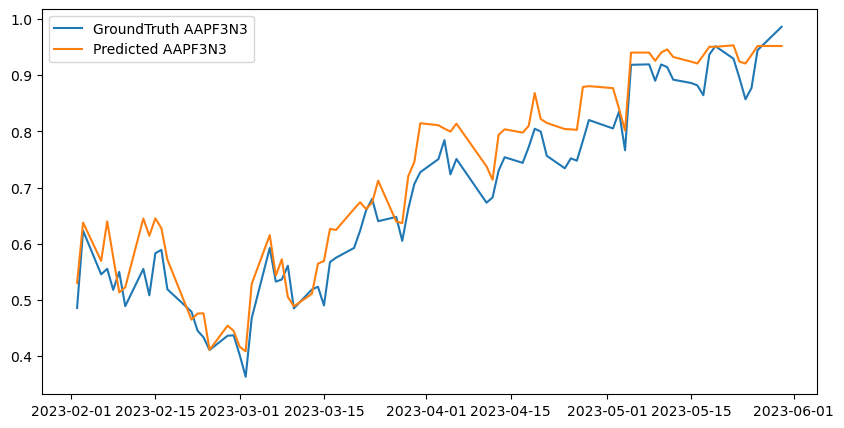

In [55]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)
model.fit(X_train, y_train)

print('Accuracy score:', model.score(X_test, y_test))

predicted_vals = model.predict(X_test)

print('Pearson correlation:', pearsonr(y_test, predicted_vals)[0])

plt.figure(figsize=(10, 5))
plt.plot(X_test.index, y_test, label = 'GroundTruth AAPF3N3')
plt.plot(X_test.index, predicted_vals, label = 'Predicted AAPF3N3')
plt.legend()

A new LSTM unfair prediction is not useful in this case since it would be the exact same as the one computed at the very first step. 

<h3> 2. Fair prediction

Ultimate single value prediction using all the additional information in both the random forest and in the LSTM.

***Single value - RANDOM FOREST***

In [56]:
X = df.loc[:, df.columns != 'AAPF3N3'][:-1]
y = df['AAPF3N3'].shift(-1).dropna()
split = len(X) - 1

X_train, y_train, X_test, y_test = X[:split], y[:split], X[split:], y[split:]

In [57]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)
model.fit(X_train, y_train)


predicted_val = model.predict(X_test)

print('Accuracy score:', 1 - (predicted_val[0] - y_test[0])**2)
print('Predicted value:', predicted_val[0])
print('GroundTruth value:', y_test[0])

Accuracy score: 0.9973582206918469
Predicted value: 0.9346523867785396
GroundTruth value: 0.9860506290456943


A sliding window approach in this case would again be the same as the very first one computed so it has not been done a second time. <br><br>
An approach trying to predict each timestep all the explanatory variables could be a possible alternative, but not really feasible since it would mean that each time too many series would need to be predicted, and that would introduce too much error.

<hr>

# Conclusions

Multiple approeaches have been tried, some more complicated than others, to try to predict the future price of a contract. <br>
This project showed both good and bad results about each method. In the end, as expected, we can conclude that predictions are feasible in the short term, because there isn't a big amount of unknowns, while being definitely much harder for values further in the future. 
<br><br>
This experiment also proved how sometimes a good sentiment analysis could help in these kind of problems, but it is still not enough to have accurate predictions because of the very randomic behaviour of the market.
<br><br>
Altough it might seem less accurate than the very first method, it's still probably better because incorporating more information as the indipendent variables in surely better because its error is much less variance influenced, so overall the last model is surely the most robust.